In [4]:
'''
URJC / GIA / Aprendizaje Automático 1 / Curso 23-24
alfredo.cuesta@urjc.es
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

np.set_printoptions(precision=2)
pd.set_option("display.precision", 4)
seed = 1460

# Árboles de decisión

Si tenemos que tomar una decisión para clasificar los ejemplos atendiendo sólo a una de las carácterísticas:
- ¿Cuál elegiríamos?
- ¿Qué aspecto tiene la superficie de decisión?

Para decidir la característica necesitamos un criterio de tal manera que la característica elegida sea aquella que mejor puntuación tiene según ese criterio.

El criterio debe relacionar las características con la etiqueta o el valor objetivo. <br>
> <i>¿Podría ser la correlación?</i><br>
Como ya sabemos, la correlación sólo indica la relación lineal entre dos variables.
Si tenemos un problema de clasificación binariala etiqueta es un vector de ceros y unos, por lo que dificilmente podemos hablar de una relación lineal con una característica.

Tenemos otras dos opciones:
- Ganancia de información
- Índice de Gini


## Ganancia de Información

La idea es elegir aquella característica que **más información** nos aporte sobre la etiqueta.

Pero **¿qué es la información?**

Según Claude E. Shannon, padre de la *Teoría de la Información*, **Información es la reducción de incertidumbre**
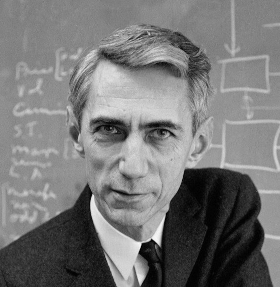


### Entropía e Incertidumbre

Un concepto esencial de la Teoría de infomación es la **Entropía** como medida de la incertidumbre que tenemos sobre un suceso que va a ocurrir.
- Si sabemos que tiene probabilidad 100% de ocurrir, entonces no hay ninguna incertidumbre y la entropía de esa variable "aleatoria" (entre comillas porque realmente no lo es) es CERO.
><small> <u>Ejemplo</u>. <br>
Si introducimos en una bolsa $M$ bolas del mismo color, NO hay ninguna incertidumbre sobre el color de la bola que sacaremos.</small>
- En caso de que haya una cierta probabilidad sobre el suceso $p(x)$ entonces su entropía es

$$
E = - \sum\limits_{\forall x} p(x) \log_2 p(x)
$$

><u>Ejemplo</u>. <br>
Si tenemos una bolsa con $M = M_0 + M_1$ bolas,
 tal que $M_0$ son el número de bolas tipo 0  y
 $M_1$ son el número de bolas tipo 1, entonces:
  -  La probabilidad _aproximada_ de sacar una bola es:
  $$
  \begin{align}
    \quad p(y=0) &= \frac{M_0}{M}, \quad \text{para las de tipo 0}
    \\
    \quad p(y=1) &= \frac{M_1}{M},\quad \text{para las de tipo 1}
  \end{align}
  $$
  - De modo que la entropía de $y$ es:
  
$$
E = \left(-\frac{M_0}{M}\log_2\frac{M_0}{M} \right)
+  \left(-\frac{M_1}{M}\log_2\frac{M_1}{M} \right)
$$


### La entropía como criterio de selección de características

En esta explicación asumimos que se trata de un problema de clasificación binaria es decir $y^{(i)}\in\{0,1\}$ para $i=1,2,\ldots,N$.

**1.** Comenzamos calculando la entropía de toda la tabla. <br>
Para ello observamos SOLO la columna de la etiqueta, de modo que

$$
E_T = \left(-\frac{N_{y=0}}{N}\log_2\frac{N_{y=0}}{N} \right)
+  \left(-\frac{N_{y=1}}{N}\log_2\frac{N_{y=1}}{N} \right)
$$

**2.** A continuación observamos la característica de la tabla de datos de entrenamiento, que por sencillez asumiremos binaria, $x_i\in\{0,1\}$.

Entonces podemos calcular dos entropías de $~y~$ para dicha columna $i$:
  - $E_{x_i = 0}$ es la Entropía de $~y~$ cuando $x_i = 0$
  - $E_{x_i = 1}$ es la Entropía de $~y~$ cuando $x_i = 1$

Así tenemos dos medidas de incertidumbre sobre la etiqueta, ¿con cuál nos quedamos? $\rightarrow$ con LOS DOS.

O mejor dicho, con una suma ponderada de ambos.

Para calcular los pesos de cada una recurrimos al número de ejemplos de cada caso respecto del número total de ejemplos. Sea:
- $N_{x_i = 0}$ el número de ejemplos con $x_i = 0$
- $N_{x_i = 1}$ el número de ejemplos con $x_i = 1$

Entonces la suma ponderada de las dos entropías es

$$\frac{N_{x_i = 0}}{N} E_{x_i = 0} + \frac{N_{x_i = 1}}{N} E_{x_i = 1} $$

**3.** La *Ganancia de información* es la reducción en la incertidumbre debida a dividir la tabla en dos partes: aquellas filas con $~x_i = 0~$ y aquellas con $~x_i = 1;$ es decir

$$
G_{x_i} = E_T - (\frac{N_{x_i = 0}}{N} E_{x_i = 0} + \frac{N_{x_i = 1}}{N} E_{x_i = 1})
$$

**4.** Hay que repetir los pasos 2 y 3 para cada $~i=1,2,\ldots,N$.

Como resultado tendremos una $G$ mayor que todas las demás. <br>
La característica que ha dado lugar a esa $G$ es la que mayor información nos da sobre la etiqueta.

### Ejemplo

In [5]:
def entropy(X):
  # Esta función asume que X es una variable aleatoria
  # que solo puede tomar dos valores {0,1},
  # es decir tiene una distribución de Bernoulli.
  if X.nunique() == 1:
    return 0 #<- no hay incertidumbre, E = 0
  else:
    p_X1 = X.sum() / X.shape[0]
    p_X0 = 1 - p_X1
    E = -p_X1 * np.log2(p_X1) - p_X0 * np.log2(p_X0)
    return E

In [6]:
def entropy_mean(df):
  # Esta función asume que el df recibido tiene dos columnas
  #  - la primera es la característica seleccionada
  #  - la segunda es la etiqueta
  x,y = df.columns
  E_0 = entropy(df[df[x]==0][y])
  N_0 = df[df[x]==0].shape[0]
  E_1 = entropy(df[df[x]==1][y])
  N_1 = df[df[x]==1].shape[0]
  N = N_0 + N_1
  return (N_0/N)*E_0 + (N_1/N)*E_1

In [7]:
def info_gain(E_t, list_E):
  return [E_t - e for e in list_E]

In [8]:
# Crear un DataFrame de juguete con caracterísitcas binarias
df = pd.DataFrame({
  'x1': [1, 0, 1, 0, 1],
  'x2': [0, 1, 1, 1, 0],
  'Y':  [0, 1, 1, 0, 0]
})
print(df)

   x1  x2  Y
0   1   0  0
1   0   1  1
2   1   1  1
3   0   1  0
4   1   0  0


In [9]:
#- Entropía de la tabla
E_df = entropy(df['Y'])
print(f"Entropía de la tabla = Entropía de Y = {E_df:.4f}")

Entropía de la tabla = Entropía de Y = 0.9710


In [10]:
#- Entropía promedio de Y probando con cada característica
list_E = []
for col in df.columns:
  if col != 'Y':
    list_E.append( entropy_mean(df[[col,'Y']]) )
    print(f'\nCaracterística {col}')
    print(f'-> con {col} = 0\n', df[df[col]==0])
    print(f'-> con {col} = 1\n', df[df[col] == 1])
    print(f'Entropía promedio = {list_E[-1]:0.4f}')


Característica x1
-> con x1 = 0
    x1  x2  Y
1   0   1  1
3   0   1  0
-> con x1 = 1
    x1  x2  Y
0   1   0  0
2   1   1  1
4   1   0  0
Entropía promedio = 0.9510

Característica x2
-> con x2 = 0
    x1  x2  Y
0   1   0  0
4   1   0  0
-> con x2 = 1
    x1  x2  Y
1   0   1  1
2   1   1  1
3   0   1  0
Entropía promedio = 0.5510


In [11]:
#- Ganancia de información con cada característica
list_G = info_gain(E_df, list_E)
G = pd.DataFrame(list_G, index = df.columns[:-1], columns=['G'] )
X_sel = G['G'].idxmax()
print(f'\nLas ganancias de información son:')
print(G)
print(f'--> La característica elegida es {X_sel}')


Las ganancias de información son:
       G
x1  0.02
x2  0.42
--> La característica elegida es x2


## Índice de Gini
Dada una tabla de ejemplos asociada al vector $\bf y$ que contiene las etiquetas de cada ejemplo, el índice de impureza de Gini se calcula como:
$$
I = 1- \sum\limits_{k=1}^{n_c}p(y=k)^2,
$$
donde $n_c$ representa el número de clases distintas; y la probabilidad de una clase se aproxima por el número de veces que aparece esa clase entre el total de ejemplos; es decir $~p(y=k) = \frac{N_{y=k}}{N}$.

En el caso particular de clasificación binaria, donde $y\in\{0,1\}$ el índice de impureza de Gini queda:

$$
I = 1 - \left( \frac{N_{y=0}}{N} \right)^2 - \left( \frac{N_{y=1}}{N} \right)^2
$$



### El índice de Gini criterio de selección de características

El proceso es **exactamente** el mismo que con la entropía, con la diferencia de que se utiliza $I$ en vez de $E$.

En resumen: por cada característica se calcula el índice de Gini para cada clase y después se calcula el índice de Gini promedio para esa característica y se compara con el índice de Gini de la tabla completa.

Con la entropía, $G$ mide la ganancia de información, que es la reducción de incertidumbre. <br>
Del mismo modo, con el índice de impureza de Gini, $G$ mide la ganancia de pureza, que es la disminución de impureza.

### Ejemplo

In [12]:
#- Crear las funciones "gini", "gini_mean" y "gini_gain"

def gini(X):
  # Esta función asume que X es una variable aleatoria
  # que solo puede tomar dos valores {0,1},
  # es decir tiene una distribución de Bernoulli.
  if X.nunique() == 1:
    return 0 #<- no hay incertidumbre, E = 0
  else:
    p_X1 = X.sum() / X.shape[0]
    p_X0 = 1 - p_X1
    E = 1 - (p_X1)**2 - (p_X0)**2
    return E

def gini_mean(df):
  # Esta función asume que el df recibido tiene dos columnas
  #  - la primera es la característica seleccionada
  #  - la segunda es la etiqueta
  x,y = df.columns
  G_0 = gini(df[df[x]==0][y])
  N_0 = df[df[x]==0].shape[0]
  G_1 = gini(df[df[x]==1][y])
  N_1 = df[df[x]==1].shape[0]
  N = N_0 + N_1
  return (N_0/N)*G_0 + (N_1/N)*G_1

def gini_gain(I_t, list_I):
  return [I_t - i for i in list_I]

In [13]:
#- Utilizamos el MISMO dataframe que en el ejemplo anterior
print(df)
#- Índice de impureza de Gini de la tabla
  ##################
  #    Completar   #
  ##################

#- Índice de Gini promedio de Y probando con cada característica
  ##################
  #    Completar   #
  ##################

#- Selección de la característica basada en Gini
  ##################
  #    Completar   #
  ##################

   x1  x2  Y
0   1   0  0
1   0   1  1
2   1   1  1
3   0   1  0
4   1   0  0


## ¿Cómo se construye un árbol de decisión?

Los árboles son estructuras de datos recursivas:
- Un árbol consta de un nodo y ramas.
- Cada rama da lugar a un árbol o a un nodo hoja.

Así, el proceso de construcción de un árbol de decisión sigue el mismo proceso:
1. Dada una tabla de datos, se elige aquella característica que maximiza $G$ según un cierto criterio; por ejemplo la Entropía $(E)$ o el índice de impureza de Gini $(I)$.<br>
$\rightarrow$ Dicha característica da lugar a dos ramas (suponiendo un problema de clasificación binario)
2. Repetir el proceso 1 por la rama de la **izquierda** con la tabla resultante de quedarse con aquellos ejemplos que tienen la característica elegida = **"0"**.
3. Repetir el proceso 1 por la rama de la **derecha**  con la tabla resultante de quedarse con aquellos ejemplos que tienen la característica elegida = **"1"**.

Este proceso se detiene cuando ya queda tabla, pero eso implica **memorizar los datos en la estructura del árbol** = **¡¡Sobreajustar!!**

Para evitar el sobreajuste es necesario "podar" el árbol, es decir detener el proceso con algún criterio como (a elegir):
- haber alcanzado un cierto número de nodos
- haber alcanzado una cierta profundidad

Evidentemente, si elegimos un número muy bajo de nodos o de profundidad estaremos construyendo un árbol demasiado sencillo, es decir **subajustando**, que es igual de malo.

Obviamente, una vez que hemos aprendido los conceptos esenciales de árboles de decisión recurrimos a la clase de Python `sklearn.tree.DecisionTreeClassifier` para aprenderlos y utilizarlos.

# Generalización a características de cualquier tipo

El ejemplo de juguete que hemos visto al explicar los criterios de Entropía y Gini utilizaba características binarias. ¿Qué ocurre si una característica es categórica o continua?

- Si es categórica podemos utilizar una codificación one-hot y convertirla en varias características binarias.
- Tambień se puede reordenar la tabla según esa característica de menor a mayor y hacer una separación por cada categoría.


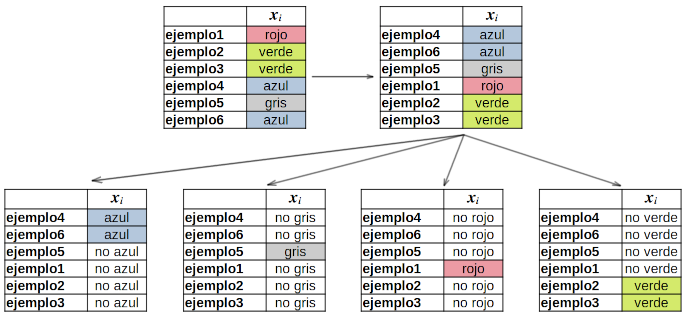

A partir de esa división, el resto sería igual que el ejemplo, pero ahora cada columna tendría varios candidatos. Es decir:
- Comenzariamos contanto el número de veces que $y=1$ para los ejemplos azules y lo mismo para los ejemplos no-azules.<br> De esta división obtendríamos una entropía promedio.
- Luego repetiriamos el proceso con los ejemplos grises y no-grises; etc etc.

Si una columna es continua, podríamos dividirla en varios cubos. Por ejemplo una característica continua en el intervalo $[0,1]$ se puede dividir en intervalos de 0.1.

# Ejercicios

Realizar un código que obtenga calcule la mejor división posible en términos de ganancia de información para la tabla de abajo. Intenta realizar después los cálculos con papel, bolígrafo y calculadora científica:

|$x_1$ |$x_2$ | $x_3$ | $y$  |
|:----:|:----:|:-----:|:----:|
|  0   |  1   | 0.27  |  1   |
|  0   |  1   | 0.13  |  1   |
|  0   |  1   | 0.86  |  0   |
|  0   |  2   | 0.97  |  1   |
|  0   |  3   | 0.56  |  0   |
|  0   |  3   | 0.16  |  0   |
|  0   |  3   | 0.82  |  1   |
|  0   |  3   | 0.26  |  1   |
|  1   |  1   | 0.93  |  1   |
|  1   |  2   | 0.64  |  0   |
|  1   |  2   | 0.15  |  1   |
|  1   |  2   | 0.17  |  0   |
|  1   |  2   | 0.87  |  1   |
|  1   |  3   | 0.64  |  1   |
|  1   |  3   | 0.32  |  0   |
|  1   |  3   | 0.11  |  1   |
|  1   |  3   | 0.04  |  0   |


Repite el último ejercicio de SVM pero utilizando árboles de decisión, incluyendo la visualización en 2 dimensiones utilizando PCA.